# Lab 2A: Audio Processing

Audio is mathematically modeled as a function $x(t)$ in which $t$ represents time and $x(t)$ is an electric signal that is generated by transforming pressure waves with a microphone. The same pressure waves can be reconstructed from the electrical signal using a speaker. 

We can create a digital representation of an audio signal through sampling. To do so define a sampling time $T_s$ and a number of components $N$ and proceed to sample the signal $x(t)$ every $T_s$ units of time. This results in the digital audio signal $\mathbf{x}$, which is mathematically represented by the vector

\begin{equation}\tag{1}   
   \mathbf{x} 
      ~=~ [x(0); x(T_s); x(2T_s); \ldots; x((N-1)T_s) ] 
      ~=~ [x_0; x_1; x_2; \ldots; x_{N-1}]  .
\end{equation}

A digital audio signal is more convenient than the original analog representation because it is easier to process. The vector $\mathbf{x}$ can be manipulated to extract information or make it better in a number of ways. In this lab we have excerpts of human speech that are contaminated with background noise. Our goal is to remove as much of the background noise as possible.

## Task 1 

Load audio data dataA.zip. Unzip it. This file contains a pytorch tensor with Q = 1500 pairs of audio recordings $(\mathbf{x}_q, \mathbf{y}_q)$.
The signals $\mathbf{x}_q$ are human speech recorded with background noise. The signals $\mathbf{y}_q$ are the same speech files recorded without background noise. Each of these audio signals contains $N=64000$ samples recorded with a sampling time of $T_s = 17 \mu s$. Play sample speech recordings for clean and contaminated audio.

/Users/juanelenter/miniconda3/envs/try_stuff/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


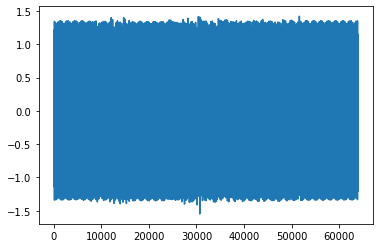

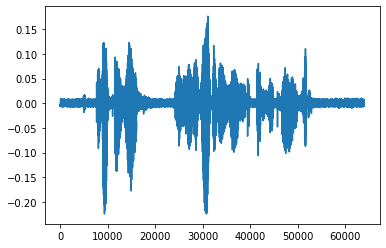

In [1]:
import torch
import matplotlib.pyplot as plt
from IPython.display import Audio
import numpy as np

dataA = torch.load('dataA.pt')
sample_rate = 16000

# Data consist of a list of 1500 (x,y) tuples.

# Take one sample and separate x and y
data_0 = dataA[0]
x_0 = data_0[0]
y_0 = data_0[1]


# Noisy signal plot and play
plt.plot(x_0[0])
plt.show()
display(Audio(x_0[0],rate=sample_rate))

# Original signal plot and play
plt.plot(y_0[0])
plt.show()
display(Audio(y_0,rate=sample_rate))


It is clear that this is a problem that we can formulate as an empirical risk minimization (ERM). Given audio inputs $\mathbf{x}$ contaminate with background noise we want to produce estimates $\hat{\mathbf{y}}$ of the corresponding clean audio signals $\mathbf{y}$. Using a learning parametrization that produces estimates $\hat{\mathbf{y}}=\mathbf{\Phi}(\mathbf{x}; \mathbf{h})$ we want to find the parameter $\mathbf{h}$ that minimizes the empirical risk over the $Q$ audio pairs for a given loss function $\ell(\mathbf{y},\hat{\mathbf{y}})$, 

\begin{equation}\tag{2}  
   \mathbf{h}^* = argmin_{\mathbf{h}} 
            \frac{1}{Q} \sum_{q=1}^Q  \ell
            \Big(\,\mathbf{y}_q,\,\mathbf{\Phi}(\mathbf{x}_q; \mathbf{h}) \,\Big).
\end{equation}

It is interesting that this mathematical formulation is searching for an artificial intelligence (AI) that is trying to *undo* a natural effect -- rather than mimicking a natural effect. The original data are clean audio inputs $\mathbf{y}_q$. These data are contaminated with background noise to produce the audio files $\mathbf{x}_q$. Our AI takes as inputs these signals contaminated with background noise and attempts to estimate the clean audio signals that generated the data contaminated with background noise. This difference in interpretation of the role of the AI does not alter the mathematical formulation of the ERM problem. 

Throughout this lab we will use $L_1$ losses to compare clean audio signals and their estimates. The $L_1$ loss is defined as the sum of the absolute values of individual component differences. If we write $\mathbf{y} = [y_0; \ldots; y_{N-1}]$ and $\hat{\mathbf{y}}=[\hat{y}_0; \ldots; \hat{y}_{N-1}]$ the $L_1$ loss is given by

\begin{equation}\label{eqn_audio_erm}  
   \ell \big(\, \mathbf{y},\,\hat{\mathbf{y}} \,\big) 
      ~=~ \big|\, \mathbf{y} - \hat{\mathbf{y}} \,\big| 
         ~=~ \sum_{n=0}^{N-1} 
                 \big|\, y_n - \hat{y}_n \,\big| .
\end{equation}

We are now ready to make a first attempt at training an AI to remove background noise from audio signals.

# Task 2

Split the data loaded in Task 1 into a test set with 100 samples and a training set containing the remaining samples. Use as learning parametrization a neural network with $N_1 = 100$ hidden neurons in a single layer.

Evaluate the training and test error. Play some sample speech recordings of entries of the test dataset after they are cleaned with the neural network. You are likely surprised by the sound. Comment.



In [2]:
# Split into train and test

test_size = 100
train_size = len(dataA) - test_size

train_set_FCNN, test_set_FCNN =  torch.utils.data.random_split(dataA, [train_size, test_size])

In [3]:
import torch.nn as nn
import torch.functional as F

# define Neural network class as in lab 1
class FCNN(nn.Module):
    def __init__(self, n_input, n_channel=32):
        super().__init__()
        
        self.linear1 = nn.Linear(n_input, 100, bias=True)
        self.linear2 = nn.Linear(100, n_input, bias=True)


    def forward(self, x):
        x = self.linear1(x)
        x = nn.functional.relu(x)
        x = self.linear2(x)
        return x

# Function to evaluate dataset from dataloader

def evaluate(dataloader, estimator):
    mse = 0
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            yHat = estimator.forward(x_batch)
            mse += torch.mean((yHat-y_batch)**2)
    numBatchs = len(dataloader)
    mse /= numBatchs
    return mse.item()

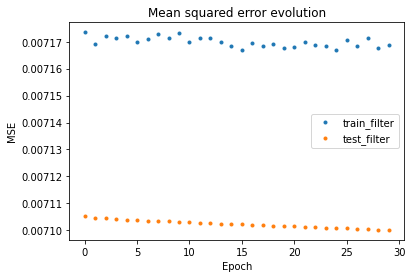

In [4]:
import torch.optim as optim
from torch.utils.data import DataLoader

estimator = FCNN(64000)

lr=0.01
batch_size = 128

optimizer = optim.SGD(estimator.parameters(), lr=lr)
loss_L1 = nn.L1Loss()


# Instantiate Data Loaders
train_loader_FCNN = DataLoader(
    train_set_FCNN,
    batch_size=batch_size,
    shuffle=True,
)

test_loader_FCNN = DataLoader(
    test_set_FCNN,
    batch_size=batch_size,
    shuffle=False,
)

mse_evolution = []
mse_evolution_test = []


# Training loop

n_epochs = 30
# Iterate n_epochs times over the whole dataset.

for ep in range(n_epochs):
    i=0
    #iterate over all batches in the dataset
    for x_batch, y_batch in train_loader_FCNN:
        i+=1
        # set gradients to zero
        estimator.zero_grad()
       
        # Compute predictions
        yHat = estimator.forward(x_batch)

        # Compute error
        #mse = torch.mean((yHat-y_batch)**2)
        mse = loss_L1(yHat,y_batch)
        mse.backward()


        # Update parameters
        optimizer.step()

    epoch_mse_filter = evaluate(train_loader_FCNN, estimator)    
    mse_evolution.append(epoch_mse_filter)
    
    mseTest_filter = evaluate(test_loader_FCNN, estimator)  
    mse_evolution_test.append(mseTest_filter)
    print(f'epoch {ep+1} / {n_epochs}',end='\r')

# Plot results
_ = plt.plot(mse_evolution, ".", label="train_filter")
_ = plt.title("Mean squared error evolution")
_ = plt.xlabel("Epoch")
_ = plt.ylabel("MSE")
_ = plt.plot(mse_evolution_test, ".", label="test_filter")
_ = plt.legend()



In [5]:
# Listen to the samples

# (change to try other audios)
nmbr_example = 7


sample_x, sample_y =dataA[nmbr_example]
predicted_y = estimator(sample_x.reshape([1,1,-1]))[0].detach()

print(f'Original Audio')
display(Audio(sample_y, rate=sample_rate))

print(f'Noisy Audio')
display(Audio(sample_x, rate=sample_rate))

print(f'Audio recovered with filter')
display(Audio(predicted_y, rate=sample_rate))


Original Audio


Noisy Audio


Audio recovered with filter


The neural network in Task 2 has failed to clean the audio files. This is a surprise because we have seen neural networks work in Lab 1C and the problem formulation in (2) is essentially the same problem formulation. What has changed between Lab 1C and Lab 2A is dimensionality. In Lab 1Aa we were processing signals with $N=2$ components. We are now processing signals with $N=64,000$. The complexity of the data is such that a neural network fails to learn any meaningful action that may result in removal of background noise. 

This phenomenon is typical. When we consider problems in which the input dimension is small pretty much any learning parametrization works fine. Neural networks, in particular, work well and have become a de-facto standard. When we consider signals in high dimensions, not all parameterizations work well. Finding good parameterizations requires that we leverage the structure of the signal. In the case of signals in time, this is done with convolutions.


Convolutions are linear operations that we use to process time signals. Consider then an input signal $\mathbf{x}$ with $N$ components $x(n)$ along with a *filter* $\mathbf{h}$ having $K$ coefficients $h(k)$. The convolution of the filter $\mathbf{h}$ with the signal $\mathbf{x}$ is a signal $\mathbf{y}= \mathbf{h} * \mathbf{x}$. This signal has $N$ components $x(n)$ which are given by

\begin{equation}\tag{3}  
   y(n) = \sum_{k=0}^{K-1} h(k) x(n-k), \quad
\end{equation}

In this definition we adopt the convention that $x(n-k)=0$ whenever the argument $(n-k) \notin [0,N-1]$. This is needed because for some values of $n$ and $k$ we may have that $n-k$ is outside of the range $[0,N-1]$ -- for example, when $n=0$ and $k>0$. When this happens $x(n-k)$ is not defined. It follows that without the adoption of some convention for these values of the index $(n-k)$ the definition in (3) is improper. This convention  is called a border artifact and it is not a significant issue if $K \ll N$. This is not required in the definition in (3) but it is almost always true in practice.

# TASK 3

Implement a class to represent convolutional filters with $K$ taps. In this class $K$ is an initialization parameter and the filter taps $h_k$ are class attributes. Endow the class with a forward method that takes a signal $\mathbf{x}$ as an input and produces as an output the signal $\mathbf{y}= \mathbf{h} * \mathbf{x}$. 

In [6]:
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.functional as F

# Define the convolutional function

def convolution_1D(signal,filter):
    taps = filter.shape[-1]
    z = torch.zeros(signal.shape)
    for k in range(taps):
        z = z + signal * filter[k]
        signal = signal.roll(1)
        signal[:,0] = 0
    return z

# Define the convolutional class

class convolutional_layer(nn.Module):
    def __init__(self,taps):
        super().__init__()
        self.filter = torch.nn.Parameter(torch.ones(taps))

    def forward(self,x):
        return convolution_1D(x,self.filter)

# Task 4

Split the data loaded in Task 1 into a test set with 100 samples and a training set containing the remaining samples. Use the class of Task 3 to train a convolutional filter with $K = 81$ taps to remove background noise.

Evaluate the test error. Play some sample speech recordings of entries of the test dataset after they are cleaned with the neural network.

In [7]:
test_size = 100
train_size = len(dataA) - test_size

train_set_filter, test_set_filter =  torch.utils.data.random_split(dataA, [train_size, test_size])

In [8]:
# SAME TRAINING LOOP BUY WITH CONV_LAYER AS ESTIMATOR


estimator = convolutional_layer(taps = 81)

lr=0.01
batch_size = 128

optimizer = optim.SGD(estimator.parameters(), lr=lr)
loss_L1 = nn.L1Loss()


# Instantiate Data Loaders
train_loader_CL = DataLoader(
    train_set_filter,
    batch_size=batch_size,
    shuffle=True,
)

test_loader_CL = DataLoader(
    test_set_filter,
    batch_size=batch_size,
    shuffle=False,
)

mse_evolution_test = []

# Training loop

n_epochs = 30
# Iterate n_epochs times over the whole dataset.

for ep in range(n_epochs):
    i=0
    #iterate over all batches in the dataset

    for x_batch, y_batch in train_loader_CL:
        i+=1
        # set gradients to zero
        estimator.zero_grad()
       
        # Compute predictions
        yHat = estimator.forward(x_batch)

        # Compute error
        mse = loss_L1(yHat,y_batch)

        mse.backward()

        # Update parameters
        optimizer.step()
    
    
    mseTest_filter = evaluate(test_loader_CL, estimator)  
    mse_evolution_test.append(mseTest_filter)
    print(f'epoch {ep+1} / {n_epochs}; loss: {mseTest_filter}',end='\r')

In [10]:
# Listen to the samples

# (change to try other audios)
nmbr_example = 1


x_batch, y_batch = next(iter(test_loader_CL))
sample_x, sample_y = x_batch[nmbr_example], y_batch[nmbr_example]
predicted_y = estimator(sample_x).detach()[0]

print(f'Original Audio')
display(Audio(sample_y, rate=sample_rate))

print(f'Noisy Audio')
display(Audio(sample_x, rate=sample_rate))

print(f'Audio recovered with filter')
display(Audio(predicted_y, rate=sample_rate))

Original Audio


Noisy Audio


Audio recovered with filter


Contrary to the fully connected neural network of Task 2, this simple linear convolutional filter works well. This illustrates the importance of leveraging signal structure in machine learning. In Lab 2B we will see how to use convolutions to construct convolutional neural networks.
